In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Feature engineering

### Commuter trips

Commuter trips can be defined as trips with the following characteristics: 
<ul>
<li>Trips originating during the rush hour times (early mornings, mornings, afternoons, late afternoons and late evenings)<br></li>
<li>Typically short distances (i.e. less than 5 miles)<br></li>
<li>Only originating and ending on weekdays<br></li>
<li>Start station not being same as the end station i.e. distance between stations is not zero (to eliminate leisure trips from tourists or returned bikes)<br></li>
</ul>

We could possibly add another criteria of filtering out only paid "annual subscribers". However, applying that criteria might lead to an inadvertent removal of commuters that haven't yet renewed their annual memberships or those who or sparringly use bikes for commute to workplaces. Hence for our purposes, we are not applying that criteria. 

Some data scientists might want to also combine "trip pairs" i.e. combine the combination of start and end stations and using the pair as one "trip". But that might not be a good idea considering that the bike rentals are "one-way rentals"; and commuters might only use bikes for one section of their office journey (and could use public transit or shared cabs for the other leg of their journey). Including both legs of the to-n-fro journey as separate would therefore give us a more holistic view of the most commonly used station pairs during rush hours. 


In [138]:
%%bigquery df

        select   
            start_station_name,
            end_station_name,
            distance_between_stations as distance_bet_stations_miles,
            round(avg(duration_min),2) as avg_trip_duration_minutes,
            round((count(*) / (SELECT count(*) FROM 
                                   `profound-surf-264703.bike_trip_data.bike_trip_distance_duration_station_view`
                                   where 
                                    start_station_name <> end_station_name
                                      and distance_between_stations <> 0
                                      and start_hour_str in ('Mid Morning', 'Morning', 'Evening', 'Afternoon', 'Early Afternoon')
                                      and dow_weekday='Weekday')),5) AS Pct_To_Total
        FROM 
            `profound-surf-264703.bike_trip_data.bike_trip_distance_duration_station_view` a
        where 
              start_station_name <> end_station_name
              and distance_between_stations <> 0
              and start_hour_str in ('Mid Morning', 'Morning', 'Evening', 'Afternoon', 'Early Afternoon')
              and dow_weekday='Weekday'
        group by distance_between_stations, start_station_name, end_station_name
        ORDER BY Pct_To_Total desc 

In [139]:
df

,start_station_name,end_station_name,distance_bet_stations_miles,avg_trip_duration_minutes,Pct_To_Total
0,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,0.55,5.07,0.00993
1,2nd at Townsend,Harry Bridges Plaza (Ferry Building),1.05,8.61,0.00865
2,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,0.81,13.49,0.00808
3,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),1.05,10.91,0.00804
4,Harry Bridges Plaza (Ferry Building),2nd at Townsend,1.05,9.97,0.00802
...,...,...,...,...,...
1944,Park at Olive,San Francisco Caltrain (Townsend at 4th),28.05,265.67,0.00000
1945,Paseo de San Antonio,San Francisco Caltrain (Townsend at 4th),41.37,119.08,0.00000
1946,California Ave Caltrain Station,San Francisco Caltrain (Townsend at 4th),27.70,59.22,0.00000
1947,5th St at Folsom St,Yerba Buena Center of the Arts (3rd @ Howard),0.35,3.20,0.00000


We see that even with applying our "commute trip" criteria, there are a lot of outlier records that skew our dataset. For example, the below histograms show that there are few trips that originate on a weekday with a travel distance greater than 40 miles! Clearly, these are only very special cases which can be excluded from our analysis. Additionally, we see that almost all commute trips are under 10 miles and less than 200 minutes.

Text(0, 0.5, 'Frequency')

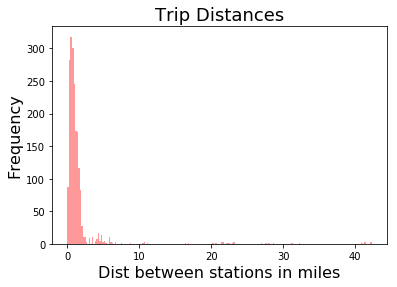

In [140]:
sns.distplot(df['distance_bet_stations_miles'], kde=False, color='red', bins=200)
plt.title('Trip Distances', fontsize=18)
plt.xlabel('Dist between stations in miles', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

Text(0, 0.5, 'Frequency')

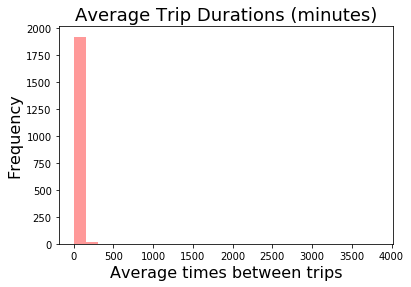

In [141]:
sns.distplot(df['avg_trip_duration_minutes'], kde=False, color='red', bins=25)
plt.title('Average Trip Durations (minutes)', fontsize=18)
plt.xlabel('Average times between trips', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

Therefore to perform a more specific and correct analysis, and to remove our outlier records, we truncate our original "commute trips" dataframe to only limit for trips that are at least 0.1% of the total trips from the original dataframe.  

Which interestingly returns 265 records (as shown in the dataframe below). Additionally, as seen further below, our feature engineering enabled dataframes of the most common commute trips (at least 0.1% of total commute trips) look much more normal. 

In [142]:
df_commute = df[df['Pct_To_Total'] > 0.001]
df_commute

,start_station_name,end_station_name,distance_bet_stations_miles,avg_trip_duration_minutes,Pct_To_Total
0,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,0.55,5.07,0.00993
1,2nd at Townsend,Harry Bridges Plaza (Ferry Building),1.05,8.61,0.00865
2,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,0.81,13.49,0.00808
3,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),1.05,10.91,0.00804
4,Harry Bridges Plaza (Ferry Building),2nd at Townsend,1.05,9.97,0.00802
...,...,...,...,...,...
260,Mechanics Plaza (Market at Battery),Market at 4th,0.47,12.90,0.00101
261,San Jose Diridon Caltrain Station,St James Park,0.93,8.71,0.00101
262,Grant Avenue at Columbus Avenue,Clay at Battery,0.38,4.10,0.00101
263,Spear at Folsom,Townsend at 7th,1.48,15.21,0.00101


Text(0, 0.5, 'Frequency')

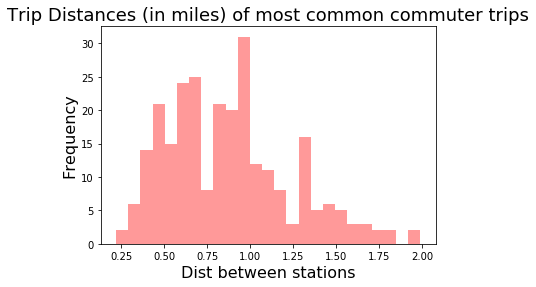

In [143]:
sns.distplot(df_commute['distance_bet_stations_miles'], kde=False, color='red', bins=25)
plt.title('Trip Distances (in miles) of most common commuter trips', fontsize=18)
plt.xlabel('Dist between stations', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

Text(0, 0.5, 'Frequency')

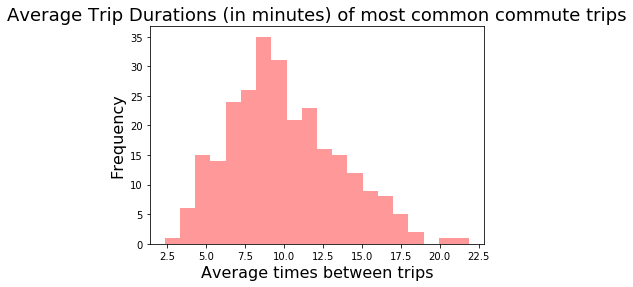

In [144]:
sns.distplot(df_commute['avg_trip_duration_minutes'], kde=False, color='red', bins=20)
plt.title('Average Trip Durations (in minutes) of most common commute trips', fontsize=18)
plt.xlabel('Average times between trips', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

In [145]:
df_commute = df_commute[0:5]
df_commute

,start_station_name,end_station_name,distance_bet_stations_miles,avg_trip_duration_minutes,Pct_To_Total
0,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,0.55,5.07,0.00993
1,2nd at Townsend,Harry Bridges Plaza (Ferry Building),1.05,8.61,0.00865
2,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,0.81,13.49,0.00808
3,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),1.05,10.91,0.00804
4,Harry Bridges Plaza (Ferry Building),2nd at Townsend,1.05,9.97,0.00802
